In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [6]:
from clustering.utils import *

Warum Modellierung?: Prüfen ob Cluster irgendeinen causalen Effekt auf Hospitalisierungen haben 
Mehrere Möglichkeiten:
- Visueller Vergleich zwischen e.g. Cluster Percentage & R-Wert/Hospitalisierungen
- Cluster Percentage als Input für das Modell (Gesamtzeitraum - eig. kein Train-Test Split benötigt)
- Erstmal Linear um Zusammenhang festzustellen
- Dann: Verbindung vermutlich nicht linear --> daher Neuronales Netz
- Abschließend ggf. Vergleich unsere Daten (Cluster oder Faktordaten) vs. Mobility Daten —> ist es ein alternativer Prediktor?

# Experiments
To Do: Model specific score with 1 cluster

In [7]:
restart_experiments = False
n_iterations = 10
methods = ['gmm_full', 'gmm_tied', 'gmm_diag', 'gmm_spherical', 'kmeans', 'nnmf']
list_n_cluster = np.arange(2,8,1)
#if restart_experiments:
#  random_seeds = np.random.randint(high=200, low=1, size=n_iterations)
#else:
random_seeds = np.array([ 51, 108,  75, 134,  26,  55,  74, 118, 128,  54])
random_seeds

array([ 51, 108,  75, 134,  26,  55,  74, 118, 128,  54])

In [6]:
#dict_results[Iteration]['Method'][Cluster_number]['Score']
if restart_experiments:
  # Create Empty Dictionary
  dict_results = {}
  for i in np.arange(n_iterations):
    dict_results_iteration = {}
    for method in methods:
      dict_temp = {}
      for n_cluster in list_n_cluster:
        dict_entry = {'silhouette_score': np.nan, 'ch_score': np.nan, 'db_score': np.nan, 'model_specific_score': np.nan}
        dict_temp.update({n_cluster:dict_entry})
      dict_results_iteration.update({method: dict_temp})
    dict_results.update({i:dict_results_iteration})

In [ ]:
if restart_experiments:
  cov_type='full'
  # Experiments
  for i in np.arange(n_iterations):
    random_seed = random_seeds[i]
    for method in methods:
      method_name = method
      if method[:3]=='gmm':
        method_name = method.rsplit('_')[0]
        cov_type = method.rsplit('_')[1]
      for n_cluster in list_n_cluster:
        answers, labels, model_specific_score = get_cluster_data_experiments(n_cluster=n_cluster, method=method_name, cov_type=cov_type, random_seed=random_seed, cluster_input_data='fa_data', start_train='2020-07-31', end_train='2020-12-01')
        dict_results[i][method][n_cluster]['model_specific_score'] = model_specific_score
        if n_cluster > 1:
          dict_results[i][method][n_cluster]['silhouette_score'] = metrics.silhouette_score(answers, labels, metric='euclidean')
          dict_results[i][method][n_cluster]['ch_score'] = metrics.calinski_harabasz_score(answers, labels)
          dict_results[i][method][n_cluster]['db_score'] = metrics.davies_bouldin_score(answers, labels)
        

In [ ]:
if restart_experiments:
  # Transform Dictionary to DataFrame
  df_results = pd.DataFrame(columns=['iteration', 'random_seed', 'method', 'number_cluster', 'silhouette_score', 'ch_score', 'model_specific_score'])
  for i in np.arange(n_iterations):
    for method in methods:
      df_temp = pd.DataFrame.from_dict(dict_results[i][method], orient='index')
      df_temp['iteration'] = i
      df_temp['random_seed'] = random_seeds[i]
      df_temp['number_cluster'] = df_temp.index
      df_temp['method'] = method
      df_results = df_results.append(df_temp)
  df_results.reset_index(inplace=True, drop=True)
  df_results.to_csv('results/clustering/results_clustering_nnmf.csv', index=False)
  df_results.head()

In [17]:
if restart_experiments:
  df_results_agg = df_results.groupby(['method', 'number_cluster']).mean().reset_index()
  df_results_std = df_results.groupby(['method', 'number_cluster']).std().reset_index()
  avg_col_list = df_results_agg.columns[2:].to_list()
  for element in avg_col_list:
    df_results_agg.rename(columns={element: element+'_avg'}, inplace=True)
    df_results_agg[element + '_std'] = df_results_std[element]
  df_results_agg.to_csv('results/clustering/results_clustering_agg_V1.csv', index=False)
  df_results_agg.head()

,method,number_cluster,iteration_avg,random_seed_avg,silhouette_score_avg,ch_score_avg,model_specific_score_avg,db_score_avg,iteration_std,random_seed_std,silhouette_score_std,ch_score_std,model_specific_score_std,db_score_std
0,gmm_diag,2,4.5,82.3,0.154042,8395.948853,-106780.789418,2.286598,3.02765,37.288813,0.000014,0.155788,0.255731,0.000018
1,gmm_diag,3,4.5,82.3,0.059828,5102.507454,-122798.354024,2.937480,3.02765,37.288813,0.000109,8.204587,17.730509,0.004170
2,gmm_diag,4,4.5,82.3,0.032828,4137.412071,-155762.305579,4.260518,3.02765,37.288813,0.009943,170.860906,175.205115,0.358952
3,gmm_diag,5,4.5,82.3,0.030629,3825.569252,-162517.769400,3.603399,3.02765,37.288813,0.000391,11.359148,17.254492,0.002804
4,gmm_diag,6,4.5,82.3,0.036471,3699.627004,-167213.944094,3.227721,3.02765,37.288813,0.001935,39.857739,78.195849,0.016233


In [8]:
if restart_experiments == False:
  df_results = pd.read_csv('results/clustering/results_clustering_V1.csv')
  df_results_agg = pd.read_csv('results/clustering/results_clustering_agg_V1.csv')

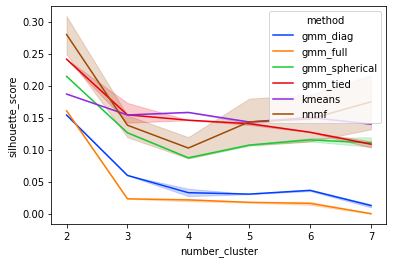

In [19]:
sns.lineplot(data=df_results, x='number_cluster', y='silhouette_score', hue='method', palette='bright') # Close to 1

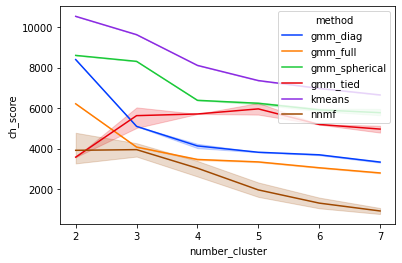

In [20]:
sns.lineplot(data=df_results, x='number_cluster', y='ch_score', hue='method', palette='bright') # Maximize

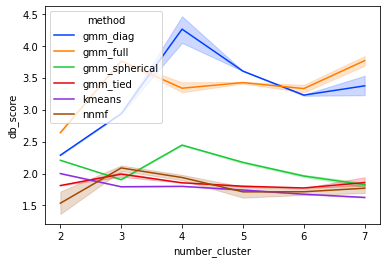

In [21]:
sns.lineplot(data=df_results, x='number_cluster', y='db_score', hue='method', palette='bright') # close to zero

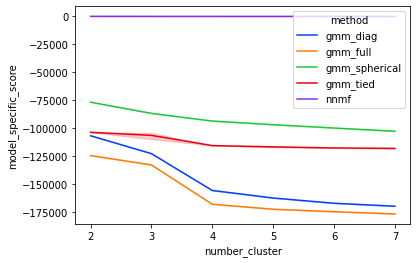

In [22]:
sns.lineplot(data=df_results[df_results['method']!='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # BIC - Minimize / find elbow

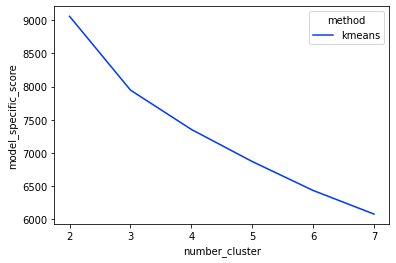

In [23]:
sns.lineplot(data=df_results[df_results['method']=='kmeans'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # Find elbow

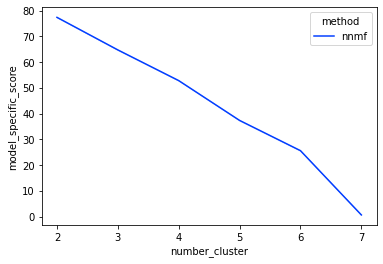

In [24]:
sns.lineplot(data=df_results[df_results['method']=='nnmf'], x='number_cluster', y='model_specific_score', hue='method', palette='bright') # Find elbow

# Calculate Ranking

In [25]:
df_results_agg[df_results_agg['number_cluster']==2].sort_values(by='silhouette_score_avg', ascending=False)#.iloc[0]

,method,number_cluster,iteration_avg,random_seed_avg,silhouette_score_avg,ch_score_avg,model_specific_score_avg,db_score_avg,iteration_std,random_seed_std,silhouette_score_std,ch_score_std,model_specific_score_std,db_score_std
30,nnmf,2,4.5,82.3,0.279776,3920.669459,77.348431,1.535078,3.02765,37.288813,0.050752,1256.921973,0.000334,0.295966
18,gmm_tied,2,4.5,82.3,0.241229,3584.091231,-103726.876189,1.811964,3.02765,37.288813,0.000217,6.826682,4.404258,0.001801
12,gmm_spherical,2,4.5,82.3,0.214454,8601.312787,-76747.244739,2.208119,3.02765,37.288813,0.000206,1.211315,0.806219,0.000547
24,kmeans,2,4.5,82.3,0.186842,10527.375674,9059.160884,1.999706,3.02765,37.288813,0.000094,0.398910,0.002148,0.000338
6,gmm_full,2,4.5,82.3,0.160635,6214.943702,-124545.561432,2.639732,3.02765,37.288813,0.000023,1.015137,0.241214,0.000280
0,gmm_diag,2,4.5,82.3,0.154042,8395.948853,-106780.789418,2.286598,3.02765,37.288813,0.000014,0.155788,0.255731,0.000018


In [26]:
n_inits = df_results_agg.shape[0] / len(methods)
ranking = []
for i in np.arange(n_inits):
  temp = np.arange(0, len(methods),1).tolist()
  ranking = ranking + temp

In [27]:
df_ranking = df_results_agg.sort_values(by=['number_cluster', 'silhouette_score_avg'])
df_ranking['ranking_silhouette'] = ranking
df_ranking.sort_values(by=['number_cluster', 'ch_score_avg'], inplace=True)
df_ranking['ranking_ch'] = ranking
df_ranking.sort_values(by=['number_cluster', 'db_score_avg'], inplace=True, ascending=False)
df_ranking['ranking_db'] = ranking
df_ranking = df_ranking.sort_values(by=['number_cluster', 'method']).reset_index(drop=True)
df_ranking['avg_ranking'] = df_ranking[['ranking_silhouette', 'ranking_ch', 'ranking_db']].mean(axis=1)
df_ranking.sort_values(by=['number_cluster', 'avg_ranking'], ascending=False)

,method,number_cluster,iteration_avg,random_seed_avg,silhouette_score_avg,ch_score_avg,model_specific_score_avg,db_score_avg,iteration_std,random_seed_std,silhouette_score_std,ch_score_std,model_specific_score_std,db_score_std,ranking_silhouette,ranking_ch,ranking_db,avg_ranking
34,kmeans,7,4.5,82.3,0.139961,6652.502755,6082.029118,1.626051,3.02765,37.288813,0.000316,3.914642,0.057819,0.008200,4,5,5,4.666667
32,gmm_spherical,7,4.5,82.3,0.110581,5777.706872,-102746.947905,1.825121,3.02765,37.288813,0.012473,260.852189,552.200924,0.054905,3,4,3,3.333333
35,nnmf,7,4.5,82.3,0.174644,930.171187,0.635990,1.769745,3.02765,37.288813,0.071872,254.192371,0.085233,0.129019,5,0,4,3.000000
33,gmm_tied,7,4.5,82.3,0.108521,4967.978452,-118103.410342,1.858733,3.02765,37.288813,0.008528,301.542070,587.556254,0.127162,2,3,2,2.333333
30,gmm_diag,7,4.5,82.3,0.012708,3340.914432,-169848.099000,3.373075,3.02765,37.288813,0.004027,39.909832,180.013821,0.243440,1,2,1,1.333333
31,gmm_full,7,4.5,82.3,0.000122,2805.522914,-176759.635004,3.767811,3.02765,37.288813,0.001049,36.125381,150.574962,0.121478,0,1,0,0.333333
28,kmeans,6,4.5,82.3,0.150310,6973.018262,6437.561188,1.676361,3.02765,37.288813,0.000316,0.639767,0.130215,0.002785,5,5,5,5.000000
27,gmm_tied,6,4.5,82.3,0.127221,5196.165013,-117723.755899,1.774000,3.02765,37.288813,0.000309,14.539932,23.282083,0.000607,3,3,3,3.000000
26,gmm_spherical,6,4.5,82.3,0.115289,5915.581552,-99880.946118,1.960460,3.02765,37.288813,0.004235,116.090992,21.417767,0.029149,2,4,2,2.666667
29,nnmf,6,4.5,82.3,0.147838,1317.628175,25.584123,1.714694,3.02765,37.288813,0.062852,441.983074,0.003082,0.081515,4,0,4,2.666667


In [28]:
for n in list_n_cluster:
  top = df_ranking[df_ranking['number_cluster'] == n].sort_values(by='avg_ranking', ascending=False).iloc[0]
  print(str(n) + ' Cluster - best method: ' + top['method'] + ' with an average score of ' + str(top['avg_ranking']))

2 Cluster - best method: nnmf with an average score of 3.6666666666666665
3 Cluster - best method: kmeans with an average score of 4.666666666666667
4 Cluster - best method: kmeans with an average score of 5.0
5 Cluster - best method: kmeans with an average score of 4.333333333333333
6 Cluster - best method: kmeans with an average score of 5.0
7 Cluster - best method: kmeans with an average score of 4.666666666666667


# Test Rand Score

In [ ]:
#dict_rand_scores[iteration][number_cluster] - avg_rand_score

In [29]:
# Create empty dict
dict_rand_scores = {}
for i in np.arange(n_iterations):
  dict_temp = {}
  for n_cluster in list_n_cluster:
    dict_temp.update({n_cluster: np.nan})
  dict_rand_scores.update({i: dict_temp})
dict_rand_scores

{0: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 1: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 2: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 3: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 4: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 5: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 6: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 7: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 8: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan},
 9: {2: nan, 3: nan, 4: nan, 5: nan, 6: nan, 7: nan}}

In [30]:
# Calc Rand Scores
for i in np.arange(n_iterations):
  random_seed = random_seeds[i]
  for n_cluster in list_n_cluster:
    cum_rand_scores = 0
    for method_1 in methods:
      df_1 = pd.read_csv('data/clustering/experiments/random_seed_' + str(random_seed) + '/' + method_1 +'_' + str(n_cluster) + '.csv')
      labels_1 = df_1['group'].to_numpy()
      for method_2 in methods:
        df_2 = pd.read_csv('data/clustering/experiments/random_seed_' + str(random_seed) + '/' + method_2 +'_' + str(n_cluster) + '.csv')
        labels_2 = df_2['group'].to_numpy()
        rand_score = metrics.adjusted_rand_score(labels_1, labels_2)
        
        #print(str(n_cluster) + ' Cluster - Comparing ' + method_1 + ' with ' + method_2 + ' - Rand Score: ' + str(rand_score))
        cum_rand_scores = cum_rand_scores + rand_score
    avg_rand_score = (cum_rand_scores-len(methods)) / ((len(methods)-1)*len(methods))
    dict_rand_scores[i][n_cluster] = avg_rand_score
    print(str(n_cluster) + ' Cluster with average rand score: ' + str(avg_rand_score))

2 Cluster with average rand score: 0.22010278543623069
3 Cluster with average rand score: 0.19107731907413605
4 Cluster with average rand score: 0.1751768874867097
5 Cluster with average rand score: 0.1652107150308995
6 Cluster with average rand score: 0.18641679255303908
7 Cluster with average rand score: 0.19340168757056933
2 Cluster with average rand score: 0.213465521995967
3 Cluster with average rand score: 0.18628038705374833
4 Cluster with average rand score: 0.17743482243486455
5 Cluster with average rand score: 0.18110225306966837
6 Cluster with average rand score: 0.19835762166025467
7 Cluster with average rand score: 0.17996912762259284
2 Cluster with average rand score: 0.2416635447888903
3 Cluster with average rand score: 0.18462807021885771
4 Cluster with average rand score: 0.1806509631469702
5 Cluster with average rand score: 0.17787774851218133
6 Cluster with average rand score: 0.2020030618545104
7 Cluster with average rand score: 0.17272057896007198
2 Cluster with av

In [31]:
# Create DataFrames
df_rand_scores = pd.DataFrame.from_dict(dict_rand_scores)
df_rand_scores['n_cluster'] = df_rand_scores.index
df_rand_scores_plot = pd.melt(df_rand_scores, id_vars='n_cluster')
df_rand_scores_plot.rename(columns={'variable': 'iteration', 'value': 'rand_score'}, inplace=True)
for i in np.arange(n_iterations):
  df_rand_scores.rename(columns={i: 'rand_score_' + str(i)}, inplace=True)
df_rand_scores['avg_rand_score'] = pd.DataFrame.from_dict(dict_rand_scores, orient='index').mean()
df_rand_scores['std_rand_score'] = pd.DataFrame.from_dict(dict_rand_scores, orient='index').std()
df_rand_scores

,rand_score_0,rand_score_1,rand_score_2,rand_score_3,rand_score_4,rand_score_5,rand_score_6,rand_score_7,rand_score_8,rand_score_9,n_cluster,avg_rand_score,std_rand_score
2,0.220103,0.213466,0.241664,0.220194,0.241359,0.233193,0.220745,0.216408,0.230835,0.256158,2,0.229412,0.013722
3,0.191077,0.186280,0.184628,0.186368,0.192926,0.191525,0.167851,0.165767,0.190113,0.187073,3,0.184361,0.009640
4,0.175177,0.177435,0.180651,0.210945,0.183504,0.176148,0.171943,0.179128,0.177846,0.183499,4,0.181628,0.010909
5,0.165211,0.181102,0.177878,0.182085,0.172840,0.187338,0.171467,0.186051,0.197987,0.185815,5,0.180777,0.009396
6,0.186417,0.198358,0.202003,0.193675,0.193128,0.200333,0.183916,0.204992,0.200506,0.188439,6,0.195177,0.007176
7,0.193402,0.179969,0.172721,0.193792,0.216525,0.190768,0.173434,0.168470,0.195034,0.187114,7,0.187123,0.014213


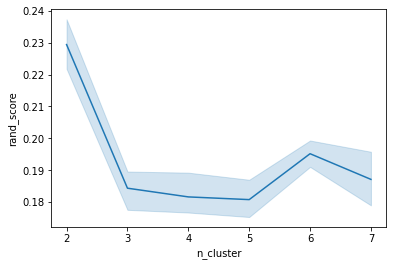

In [32]:
sns.lineplot(data=df_rand_scores_plot[df_rand_scores_plot['n_cluster'] != 1], x='n_cluster', y='rand_score', palette='bright')